In [1]:
!pip install mlflow

In [3]:
# Test mlflow

import mlflow

mlflow.set_tracking_uri("http://ec2-3-87-202-243.compute-1.amazonaws.com:5000")

with mlflow.start_run():
    mlflow.log_param("param1", 15)
    mlflow.log_metric("metric1", 0.89)

2026/02/27 12:37:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run sneaky-foal-81 at: http://ec2-3-87-202-243.compute-1.amazonaws.com:5000/#/experiments/0/runs/9896ac1cf21f42b2b34276c301cc9acd.
2026/02/27 12:37:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-3-87-202-243.compute-1.amazonaws.com:5000/#/experiments/0.


In [4]:
#creating baseline model

import numpy as np
import pandas as pd

In [29]:
df = pd.read_csv('labeled_comments.csv')
df.head()

,Comment,sentiment
0,Do you realise I discovered AI with your chane...,neutral
1,"Hold up, surgeons PUNCTURED SOMEONE'S SKULL AN...",negative
2,What really sucks is that it's good enough rig...,positive
3,Thanks for sharing it. ✌️,positive
4,"Remember Will Smith eating spaghetti, just wai...",neutral


In [30]:
df.dropna(inplace=True)

In [31]:
df.drop_duplicates(inplace=True)

In [32]:
df = df[~(df['Comment'].str.strip() == '')]

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [12]:
# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Urmi
[nltk_data]     Kanrar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Urmi
[nltk_data]     Kanrar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [34]:
df['sentiment_encoded'] = df['sentiment'].map({
    'negative': -1,
    'neutral': 0,
    'positive': 1
})

In [28]:
df.head()

,Comment,sentiment,sentiment_encoded
0,Do you realise I discovered AI with your chane...,neutral,0
1,"Hold up, surgeons PUNCTURED SOMEONE'S SKULL AN...",negative,-1
2,What really sucks is that it's good enough rig...,positive,1
3,Thanks for sharing it. ✌️,positive,1
4,"Remember Will Smith eating spaghetti, just wai...",neutral,0


In [35]:
# Define the preprocessing function
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove URLs (http, https, www)
    comment = re.sub(r'http\S+|www\S+|https\S+', '', comment)


    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [36]:
# Apply the preprocessing function to the 'clean_comment' column
df['Comment'] = df['Comment'].apply(preprocess_comment)

In [37]:
df.head()

,Comment,sentiment,sentiment_encoded
0,realise discovered ai chanel end 2022 ! world ...,neutral,0
1,"hold up, surgeon punctured someone skull cause...",negative,-1
2,really suck good enough right get like 8090 wa...,positive,1
3,thanks sharing it.,positive,1
4,"remember smith eating spaghetti, wait",neutral,0


In [38]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# Step 1: Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=10000)  # Bag of Words model with a limit of 1000 features

In [40]:
X = vectorizer.fit_transform(df['Comment']).toarray()
y = df['sentiment_encoded']  # Assuming 'sentiment' is the target variable 

In [41]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [42]:
X.shape

(3119, 9209)

In [43]:
y

0       0
1      -1
2       1
3       1
4       0
       ..
3119    0
3120    1
3121    1
3122    0
3123    1
Name: sentiment_encoded, Length: 3119, dtype: int64

In [44]:
y.shape

(3119,)

In [79]:
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-3-87-202-243.compute-1.amazonaws.com:5000")

In [80]:
# Set or create an experiment
mlflow.set_experiment("RF Baseline")

2026/02/27 17:44:38 INFO mlflow.tracking.fluent: Experiment with name 'RF Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-tracking-bucket26/1', creation_time=1772194478415, experiment_id='1', last_update_time=1772194478415, lifecycle_stage='active', name='RF Baseline', tags={}>

In [48]:
!pip install boto3

In [49]:
!pip install awscli

  Using cached docutils-0.19-py3-none-any.whl.metadata (2.7 kB)
  Using cached s3transfer-0.16.0-py3-none-any.whl.metadata (1.7 kB)
  Using cached rsa-4.7.2-py3-none-any.whl.metadata (3.6 kB)
   ---------------------------------------- 0.0/4.6 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.6 MB ? eta -:--:--
   ---- ----------------------------------- 0.5/4.6 MB 1.5 MB/s eta 0:00:03
   ------ --------------------------------- 0.8/4.6 MB 1.6 MB/s eta 0:00:03
   ----------- ---------------------------- 1.3/4.6 MB 1.8 MB/s eta 0:00:02
   --------------- ------------------------ 1.8/4.6 MB 2.1 MB/s eta 0:00:02
   ------------------ --------------------- 2.1/4.6 MB 2.0 MB/s eta 0:00:02
   ---------------------- ----------------- 2.6/4.6 MB 2.0 MB/s eta 0:00:02
   --------------------------- ------------ 3.1/4.6 MB 2.0 MB/s eta 0:00:01
   ---------------------------------- ----- 3.9/4.6 MB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 4.6/4.6 MB 2.4 MB/

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.17.0 requires botocore<1.35.94,>=1.35.74, but you have botocore 1.42.58 which is incompatible.
boto3 1.35.36 requires botocore<1.36.0,>=1.35.36, but you have botocore 1.42.58 which is incompatible.
boto3 1.35.36 requires s3transfer<0.11.0,>=0.10.0, but you have s3transfer 0.16.0 which is incompatible.


In [ ]:
!aws configure set aws_access_key_id #hided for security
!aws configure set aws_secret_access_key #hided for security
!aws configure set default.region us-east-1

c:\Users\Urmi Kanrar\anaconda3\envs\sentiment\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Urmi Kanrar\anaconda3\envs\sentiment\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Urmi Kanrar\anaconda3\envs\sentiment\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

Accuracy: 0.5144230769230769


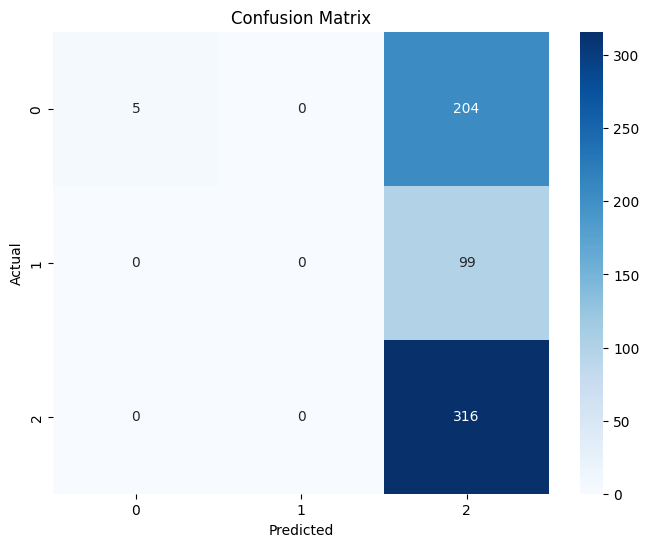

In [81]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Define and train a Random Forest baseline model using a simple train-test split
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Optionally log the dataset itself (if it's small enough)
    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("dataset.csv")

# Display final accuracy
print(f"Accuracy: {accuracy}")

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.02      0.05       209
           0       0.00      0.00      0.00        99
           1       0.51      1.00      0.68       316

    accuracy                           0.51       624
   macro avg       0.50      0.34      0.24       624
weighted avg       0.59      0.51      0.36       624



c:\Users\Urmi Kanrar\anaconda3\envs\sentiment\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Urmi Kanrar\anaconda3\envs\sentiment\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Urmi Kanrar\anaconda3\envs\sentiment\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

In [75]:
df.to_csv('youtube_preprocessing.csv', index=False)

In [76]:
pd.read_csv('youtube_preprocessing.csv').head()

,Comment,sentiment,sentiment_encoded
0,realise discovered ai chanel end 2022 ! world ...,neutral,0
1,"hold up, surgeon punctured someone skull cause...",negative,-1
2,really suck good enough right get like 8090 wa...,positive,1
3,thanks sharing it.,positive,1
4,"remember smith eating spaghetti, wait",neutral,0
